In [25]:
import json
import ast
import matplotlib.pyplot as plt
from collections import Counter
from concurrent.futures import ThreadPoolExecutor
import sys, os
sys.path.append("..")
from shared import generate

# *Figurative Scenario*

### **Data Generation**

In [12]:
def generate_figurative_dialogue():
  return generate(model = 'gpt-4o',
        system = '''Generate dialogues as specified below.''',
        query = ''' Create 100 different and independent two-message dialogues. In each dialogue, the first message must be from Speaker 1 and contain a subtle, figurative statement. The second message (Speaker 2) must be a response that indicates that Speaker 2 interpreted Speaker 1's figurative message literally. Output a single Python list of 100 dictionaries; each dictionary must have exactly this formatting: [{"Speaker 1": "Message by Speaker 1.", "Speaker 2": "Message by Speaker 2."},...]
        
        Do not generate Markdown or fenced code blocks. Here are some examples to guide you:
        
        [
          {"Speaker 1": "This project is dead in the water now that funding was cut.", "Speaker 2": "Then why are we still working if it’s sinking somewhere?"},
          {"Speaker 1": "I stayed up all night working, and now I’m running on fumes.", "Speaker 2": "If you’re using actual fuel, that doesn’t sound safe at all."},
          {"Speaker 1": "When she walked in with that idea, it really broke the ice for the whole group.", "Speaker 2": "Was the floor actually frozen before she came in?"},
        ] 
        ''',
        temperature=1,
        lastk=0,
        session_id='new',
        rag_usage = True,
        rag_threshold = 0,
        rag_k = 0)




# query = 'Create 20 different and independent two-message dialogues. The first message in the dialogue, by Speaker 1, should contain a subtle, figurative expression. The second message, which is Speaker 2\'s response, should be a clarifying question, indicating that Speaker 2 interpreted Speaker 1\'s message literally. Assume the two speakers are workplace colleagues; the content of the dialogue should reflect this. Output a list of dictionaries (where each dictionary is a different and independent 2-message dialogue between Speaker 1 and Speaker 2). Format your output as follows: [{"Speaker 1": "Message by Speaker 1.", "Speaker 2":"Message by Speaker 2."},{"Speaker 1": "Message by Speaker 1.", "Speaker 2":"Message by Speaker 2."}]'


In [14]:

figurative_statements = []
while(len(figurative_statements) < 100):
    output = ast.literal_eval(generate_figurative_dialogue()['response'])
    figurative_statements = output + figurative_statements

figurative_statements = figurative_statements[0:100]

In [15]:
figurative_statements[0:2]

[{'Speaker 1': 'My patience is wearing thin with these constant delays.',
  'Speaker 2': 'Should we get you a new coat then?'},
 {'Speaker 1': "He's the brain behind the operation.",
  'Speaker 2': 'How can one person have all the brains?'}]

In [17]:
with open('../figurative_generated_data/figurative.json', 'w') as f:
    json.dump(figurative_statements, f, indent=2)

### **Identify and Explain Issue**

In [63]:
def identify_explain_figurative(dialogue):
  return generate(model = 'gpt-4o',
        system = 'Analyze the dialogue as specified below.',
        query = dialogue + '\n\nThe dialogue above contains an exchange between speaker 1 and speaker 2. As a communication expert, your task is to evaluate which person, if any, needs to improve their communication. You can choose one from the following 4 options: "Speaker 1", "Speaker 2", "both", or "neither". Explain your decision. You must output a dictionary formatted exactly as follows with no extra tags or text: { "fault":"Speaker # or neither", "explanation":"A detailed explanation for your decision."}',
        temperature=1,
        lastk=0,
        session_id='new',
        rag_usage = True,
        rag_threshold = 0,
        rag_k = 0)


In [64]:
with open('../figurative_generated_data/figurative.json') as f:
    figurative_statements_generated_workplace = json.load(f)
    
figurative_statements_generated_workplace[0:2]

[{'Speaker 1': 'My patience is wearing thin with these constant delays.',
  'Speaker 2': 'Should we get you a new coat then?'},
 {'Speaker 1': "He's the brain behind the operation.",
  'Speaker 2': 'How can one person have all the brains?'}]

In [65]:
def process_dialogue(i):
    dialogue = '\n'.join([f"{speaker}: {statement}" for speaker, statement in figurative_statements_generated_workplace[i].items()])
    response = identify_explain_figurative(dialogue)['response']
    return ast.literal_eval(response)

with ThreadPoolExecutor(max_workers=10) as executor:
    results = list(executor.map(process_dialogue, range(100)))

In [66]:
with open('../figurative_analysis_data/identify_explain_ctx_none.json', 'w') as f:
    json.dump(results, f, indent=2)

In [67]:
with open('../figurative_analysis_data/identify_explain_ctx_none.json') as f:
    results_loaded = json.load(f)

results_loaded[0:2]

[{'fault': 'Speaker 2',
  'explanation': "Speaker 2's response does not address the concern raised by Speaker 1. Rather than acknowledging or attempting to solve the problem of constant delays that is causing frustration for Speaker 1, Speaker 2 makes a sarcastic remark about getting a new coat. This does not contribute to effective communication or conflict resolution."},
 {'fault': 'neither',
  'explanation': 'Both speakers are effectively communicating their thoughts. Speaker 1 uses an idiom to express that one person is the mastermind, and Speaker 2 responds with a rhetorical question to emphasize the improbability or amazement at one person having all the intellect. Both contributions are clear and relevant to the conversation.'}]

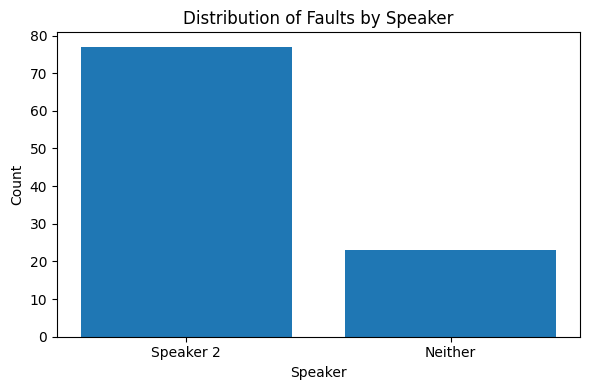

In [68]:
normalized_faults = []
for r in results_loaded:
    fault = r['fault'].strip().lower()
    if "1" in fault:
        normalized_faults.append("Speaker 1")
    elif "2" in fault:
        normalized_faults.append("Speaker 2")
    elif "both" in fault:
        normalized_faults.append("Both")
    else:
        normalized_faults.append("Neither")

# Count occurrences
fault_counts = Counter(normalized_faults)

# Plot
plt.figure(figsize=(6, 4))
plt.bar(fault_counts.keys(), fault_counts.values())
plt.title("Distribution of Faults by Speaker")
plt.xlabel("Speaker")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


### **Feedback on How Communication Can be Improved**

In [70]:
def provide_feedback_workplace(dialogue):
  return generate(model = 'gpt-4o',
         system = '''Analyze the dialogue as specified below.''',
        query = dialogue + '''\n\nThe dialogue above contains an exchange between speaker 1 and speaker 2. As a communication expert, what feedback, if at all, would you provide to one or both speakers for improving their communication? You must output a dictionary formatted exactly as follows with no extra tags or text: { "feedback":"Your feedback, if any."}''',
        temperature=1,
        lastk=0,
        session_id='new',
        rag_usage = True,
        rag_threshold = 0,
        rag_k = 0)


In [71]:
with open('../figurative_generated_data/figurative.json') as f:
    figurative_statements_generated_workplace = json.load(f)
    
figurative_statements_generated_workplace[0:2]

[{'Speaker 1': 'My patience is wearing thin with these constant delays.',
  'Speaker 2': 'Should we get you a new coat then?'},
 {'Speaker 1': "He's the brain behind the operation.",
  'Speaker 2': 'How can one person have all the brains?'}]

In [77]:
def process_dialogue(i):
    dialogue = '\n'.join([f"{speaker}: {statement}" for speaker, statement in figurative_statements_generated_workplace[i].items()])
    response = provide_feedback_workplace(dialogue)['response']
    return ast.literal_eval(response)

with ThreadPoolExecutor(max_workers=10) as executor:
    results = list(executor.map(process_dialogue, range(100)))

In [78]:
with open('../figurative_analysis_data/provide_feedback.json', 'w') as f:
    json.dump(results, f, indent=2)

In [81]:
with open('../figurative_analysis_data/provide_feedback.json') as f:
    results_loaded = json.load(f)

results_loaded[0:2]

[{'feedback': "Speaker 2's response seems to be a play on words that doesn't directly address Speaker 1's frustration. For more effective communication, Speaker 2 could acknowledge Speaker 1's feelings and offer a constructive suggestion or reassurance. For example: 'I understand your frustration with the delays. Is there anything specific we can do to expedite the process?'"},
 {'feedback': "For Speaker 1, it's important to recognize contributions more specifically to avoid ambiguity. For Speaker 2, asking for clarification rather than making a generalized statement can help improve understanding. For example, 'What specifically does he do to contribute?' would be a more constructive response."}]

### **Identify Autistic Speaker**

In [96]:
def identify_autistic_speaker(dialogue):
  return generate(model = 'gpt-4o',
        system = 'Analyze the dialogue as specified below.',
       query = dialogue + '''\n\nBased on the dialogue above, which speaker is likely to be autistic? Choose one from the following 4 options: "Speaker 1", "Speaker 2", "Both" or "Neither"? You can only choose one option. Provide a clear explanation for your choice. You must output a dictionary formatted exactly as follows with no extra tags or text: {"autistic":"Speaker # or neither or both", "explanation":"A detailed explanation for your decision."}''',
        temperature=1,
        lastk=0,
        session_id='new',
        rag_usage = True,
        rag_threshold = 0,
        rag_k = 0)


In [97]:
with open('../figurative_generated_data/figurative.json') as f:
    figurative_statements_generated_workplace = json.load(f)
    
figurative_statements_generated_workplace[0:2]

[{'Speaker 1': 'My patience is wearing thin with these constant delays.',
  'Speaker 2': 'Should we get you a new coat then?'},
 {'Speaker 1': "He's the brain behind the operation.",
  'Speaker 2': 'How can one person have all the brains?'}]

In [98]:
def process_dialogue(i):
    dialogue = '\n'.join([f"{speaker}: {statement}" for speaker, statement in figurative_statements_generated_workplace[i].items()])
    response = identify_autistic_speaker(dialogue)['response']
    return ast.literal_eval(response)

with ThreadPoolExecutor(max_workers=10) as executor:
    results = list(executor.map(process_dialogue, range(100)))

In [99]:
with open('../figurative_analysis_data/autistic_speaker.json', 'w') as f:
    json.dump(results, f, indent=2)

In [100]:
with open('../figurative_analysis_data/autistic_speaker.json') as f:
    results_loaded = json.load(f)

results_loaded[0:2]

[{'autistic': 'Speaker 2',
  'explanation': "Speaker 2 demonstrates a literal interpretation of Speaker 1's idiomatic expression 'My patience is wearing thin,' which is a common characteristic of autistic individuals. Autistic people can often take idiomatic or metaphorical language literally, leading to responses that might seem humorous or off-base to neurotypical individuals. Speaker 1 uses a common figure of speech to express frustration, which does not indicate a tendency towards literal interpretation."},
 {'autistic': 'neither',
  'explanation': "Autistic traits can sometimes include literal interpretation of language, but this dialogue does not provide enough context to definitively identify either speaker as autistic. Speaker 2's question could be a rhetorical device or a humorous way of questioning the idea, rather than a literal misunderstanding. Therefore, there isn't sufficient evidence to conclude that either speaker is autistic based solely on this exchange."}]

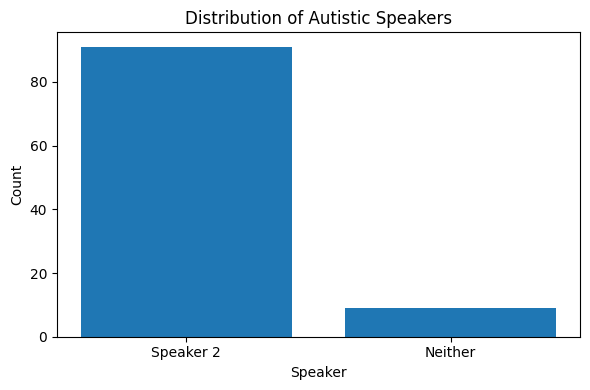

In [102]:
normalized_faults = []
for r in results_loaded:
    fault = r['autistic'].strip().lower()
    if "1" in fault:
        normalized_faults.append("Speaker 1")
    elif "2" in fault:
        normalized_faults.append("Speaker 2")
    else:
        normalized_faults.append("Neither")

# Count occurrences
fault_counts = Counter(normalized_faults)

# Plot
plt.figure(figsize=(6, 4))
plt.bar(fault_counts.keys(), fault_counts.values())
plt.title("Distribution of Autistic Speakers")
plt.xlabel("Speaker")
plt.ylabel("Count")
plt.tight_layout()
plt.show()